# SC3001 Lab Assignment 1

TODO: make this more elaborate:
Approach: Q Learning (Q-table) on quantised space.

This notebook implements a Q learning agent to balance a pole on a moving cart in the CartPole-v1 environment

1. Set up the environment and dependencies
2. Implement Q-learning to train the RL agent
3. Tests the RL agent with 100 episodes
4. Display 1 episode played by the trained RL agent.

## Installing dependencies:

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install jupyter-black > /dev/null 2>&1
# downgrade numpy < 2.0 to resolve np.bool8 missing issue with gym cartpole env
%pip install numpy==1.26.4

  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 111.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


## Importing dependencies and define helper functions

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import numpy as np
import numpy.typing as npt
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
%load_ext jupyter_black


def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

In [3]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [4]:
print(env.action_space)
n_actions = env.action_space.n

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.


In [5]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


**Observations**
Note that the observation (state) space is continuous and unbounded. This implies
a possible infinite number of states that cannot be tabulated in fixed sized
Q table.
Hence there is a need to discretise and bound the set of possible states such
that Q learning is can completing within a reasonable runtime.


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [6]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.00513513  0.00418363 -0.01415762 -0.0341421 ]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [7]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.00505145 -0.19073246 -0.01484046  0.25404054]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [8]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


## Task 1: Development of an RL agent

## State Feature Extraction
- We also need to set **bounds** on the values sampled from the observation (state) by clipping values within a finite range.
  - **Cart Position**: $-4.8 \leq \text{value} \leq 4.8$
  - **Cart Velocity**: $-4.8 < \text{value} < 4.8$
  - **Pole Angle**: $-0.418 \leq \text{value} \leq 0.418$
  - **Pole Angular Velocity**: $-0.418 \leq \text{value} \leq 0.418$

- We need to **discretise & bound** the observation space by binning values into fixed no. of buckets (bins) using the binning method described in a MATLAB implementation of the same problem [^1]:
  - **Cart Position**: 3 bins
  - **Cart Velocity**: 3 bins.
  - **Pole Angle**: 6 bins
  - **Pole Angular Velocity**: 6 bins.

  
  This allows the agent to focus on patterns formed by the finite, bounded ste of states u of dealing with infinite numbers which allows for easier decision-making and faster speed of learning.


- Finally we map each possible observation to a unique "state ID".


[^1]: https://pages.cs.wisc.edu/~finton/qcontroller.html

In [9]:
# state features: cart: position, velocity, pole: angle, angular velocity
# no. of bins to create for each feature
N_BINS = np.array([3, 3, 6, 6])
n_states = N_BINS.prod()
print(f"no. of states: {n_states}")

NPArray = npt.NDArray[np.float64]


def extract_state(state: NPArray, n_bins: NPArray = N_BINS) -> int:
    # bounds for each feature
    bound_min = np.array([-4.8, -4.8, -0.418, -0.418])
    bound_max = np.array([4.8, 4.8, 0.418, 0.418])
    clipped = np.clip(state, bound_min, bound_max)

    # bin values into discrete bins
    features = np.zeros_like(state)
    for i in range(len(state)):
        bins = np.linspace(bound_min[i], bound_max[i], n_bins[i] + 1)
        # -1 to ensure bins are 1-indexed
        features[i] = np.digitize(clipped[i], bins) - 1

    # compute state id using multi dimensional indexing
    state_id = 0
    for i, feature in enumerate(features):
        state_id += int(feature * n_bins[i + 1 :].prod())
    return state_id

no. of states: 324


## Q Learning
Since our $Q(\text{state}, \text{action})$ space is small (324 states * 2 actions = 648), we can fit Q-values entirely in memory as a Q-table.

We apply the Q learning step to update $Q(\text{state}, \text{action})$ values with parameters:
- $\gamma$ : Discount factor for future rewards.
- $\alpha$ : Learning rate for Q(s,a)-value updates per step.

$$
Q({\small state}, {\small action}) = (1 - \alpha) Q({\small state}, {\small action}) + \alpha \Big({\small reward} + \gamma \max_{a} Q({\small next \ state}, {\small all \ actions})\Big)
$$


In [10]:
def q_learn(
    q_table: NPArray,
    state: int,
    action: int,
    reward: float,
    next_state: int,
    learning_rate: float,
    discount_factor: float,
) -> NPArray:
    """
    Apply one Q-learning step to update the Q-table.

    The function updates the Q-value for a given state-action pair based on the
    Q-learning algorithm. It uses the current Q-value, the reward received for
    taking the action, and the maximum Q-value of the next state to compute the
    updated Q-value.

    Args:
        q_table (NPArray): The Q-table (a 2D array) where Q-values are stored.
        state (int): The index of the current state.
        action (int): The index of the action taken.
        reward (float): The reward received after taking the action.
        next_state (int): The index of the next state.
        learning_rate (float, optional): The learning rate for the update (default is 0.5).
        discount_factor (float, optional): The discount factor for future rewards (default is 0.999).

    Returns:
        NPArray: The updated Q-table with the new Q-value for the given state-action pair.

    Example:
        q_table = q_learn(q_table, state=1, action=2, reward=1.0, next_state=3)
    """
    q_table[state, action] = (1 - learning_rate) * q_table[
        state, action
    ] + learning_rate * (reward + discount_factor * q_table[next_state].max())
    return q_table

## Epilson Greedy
Explore /exploit the state space using $\epsilon$-greedy policy:
- **Explore** : $\epsilon$ probability of choosing a random action
- **Exploit** : otherwise $(1- \epsilon)$ probablity of choosing the optimal action using the current Q(s,a) values.

This is to prevent premature convergence on suboptimal solutions by encouraging exploration and also helps the agent discover optimal actions through a balance between exploring new possibilities and exploiting the known best options.

In [11]:
def e_greedy(q_table: NPArray, state: int, explore_rate: float) -> int:
    """
    Determine the next action using the epsilon-greedy policy.

    The epsilon-greedy policy selects a random action with probability `explore_rate`
    (exploration), and the action with the highest Q-value for the given state with
    probability `1 - explore_rate` (exploitation). This is used to balance exploration
    of the environment and exploitation of the learned policy.

    Args:
        q_table (NPArray): The Q-table (a 2D array) containing the Q-values for each state-action pair.
        state (int): The index of the current state.
        explore_rate (float, optional): The probability of selecting a random action (exploration).
                                          Default is 1e-5, meaning very little exploration.
    Returns:
        int: The index of the chosen action.

    Example:
        action = e_greedy(q_table, state=1)
    """
    if random.random() <= explore_rate:
        # random action
        return random.randint(0, 1)
    else:
        # optimal action with the highest Q value based on current Q-table values
        return q_table[state].argmax()

## Q Learning Agent
- perform Q-learning step update to Q-values using learning rate $\alpha$ & discount factor $\lambda$
- selects next action $a$ based on $\epsilon$-greedy policy.

In [12]:
class QAgent:
    def __init__(
        self,
        learning_rate: float,
        explore_rate: float,
        discount_factor: float,
        n_states: int = n_states,
        n_actions: int = n_actions,
    ):
        self.learning_rate = learning_rate
        self.explore_rate = explore_rate
        self.discount_factor = discount_factor
        # Q-table initialised with zeroes because agent knows nothing yet
        self.q_table = np.zeros((n_states, n_actions))

    def init_act(self, initial_state: NPArray) -> int:
        """Return an initial action to perform obsased on initial state"""
        initial_state_i = extract_state(initial_state)
        return e_greedy(self.q_table, initial_state_i, self.explore_rate)

    def observe_act(
        self, state: NPArray, action: int, reward: float, next_state: NPArray
    ) -> int:
        """Observe state-action transition with reward and return a next action."""
        # perform q-learning update to q values based on observed state-action transition
        state_i = extract_state(state)
        next_state_i = extract_state(next_state)
        # update the Q-table
        self.q_table = q_learn(
            self.q_table,
            state_i,
            action,
            reward,
            next_state_i,
            self.learning_rate,
            self.discount_factor,
        )
        # determine next action based on e-greedy policy
        return e_greedy(self.q_table, next_state_i, self.explore_rate)

For Task 1, we can show the observation and chosen action below:

In [13]:
agent = QAgent(learning_rate=1.0, explore_rate=1.0, discount_factor=3)
state = env.reset()
action = agent.init_act(state)
print("Observation:", state)
print("Chosen action:", action)

Observation: [ 0.04403977  0.01023005 -0.02508294 -0.04184335]
Chosen action: 1


## Training
Train the agent by:
- playing **500** episodes.
- apply **exponential decay** to learning rate $\alpha$ & discount factor $\lambda$.

Episode 0/500: Avg Reward (last 100) = 27.00
Episode 50/500: Avg Reward (last 100) = 19.88
Episode 100/500: Avg Reward (last 100) = 27.09
Episode 150/500: Avg Reward (last 100) = 49.21
Episode 200/500: Avg Reward (last 100) = 99.56
Episode 250/500: Avg Reward (last 100) = 112.85
Episode 300/500: Avg Reward (last 100) = 173.32
Episode 350/500: Avg Reward (last 100) = 339.15
Episode 400/500: Avg Reward (last 100) = 449.12
Episode 450/500: Avg Reward (last 100) = 464.92


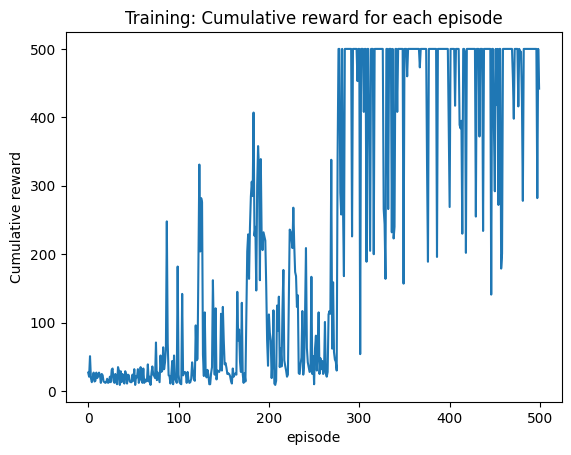

In [14]:
def play(
    env,
    agent: QAgent,
):
    """Play a single episode using the given agent"""
    # determine action based on initial state
    state = env.reset()
    action = agent.init_act(state)

    done = False
    total_reward = 0
    while not done:
        # observe and act based on next state
        next_state, reward, done, info = env.step(action)
        next_action = agent.observe_act(state, action, reward, next_state)
        # accumate rewards from agent
        total_reward += reward

        action, state = next_action, next_state
    return total_reward


def train(
    env,
    agent: QAgent,
    n_episodes: 500,
    explore_decay: float = 0.985,
    lr_decay: float = 0.99,
    min_explore: float = 0.005,  # Prevents explore_rate from reaching 0 too quickly
    min_lr: float = 0.01,  # Prevents learning rate from becoming too small
    early_stop_threshold: int = 100,  # Stop if avg reward over last 50 episodes is stable
    rng_seed=None,  # Allows flexibility (None means no fixed seed)
):
    """Train the agent by playing multiple episodes and learning from experience."""
    # seed random number generators for reproducablity
    if rng_seed is not None:
        random.seed(rng_seed)
        np.random.seed(rng_seed)
        env.seed(rng_seed)

    # play n episodes and collect cumulative (total) rewards
    total_rewards = []
    best_avg_reward = -float("inf")
    consecutive_no_improve = 0

    for i in range(n_episodes):
        total_rewards.append(play(env, agent))

        # Adjust exploration rate and learning rate dynamically
        agent.explore_rate = max(agent.explore_rate * explore_decay, min_explore)
        agent.learning_rate = max(agent.learning_rate * lr_decay, min_lr)

        # Progress tracking every 10% of training
        if i % (n_episodes // 10) == 0:
            avg_reward = np.mean(total_rewards[-early_stop_threshold:])
            print(
                f"Episode {i}/{n_episodes}: Avg Reward (last {early_stop_threshold}) = {avg_reward:.2f}"
            )

            # Early stopping condition
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
                consecutive_no_improve = 0  # Reset counter
            else:
                consecutive_no_improve += 1

            if consecutive_no_improve >= early_stop_threshold:
                print("Early stopping triggered.")
                break

    # turn off learning & exploration once agent has been trained for evaluation
    agent.explore_rate = 0.0
    agent.learning_rate = 0.0

    return agent, total_rewards


# train agent and plot results
agent = QAgent(learning_rate=1.0, explore_rate=1.0, discount_factor=0.999)
agent, rewards = train(env, agent, n_episodes=500)
plt.plot(rewards)
plt.title("Training: Cumulative reward for each episode")
plt.ylabel("Cumulative reward")
plt.xlabel("episode")
plt.show()

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

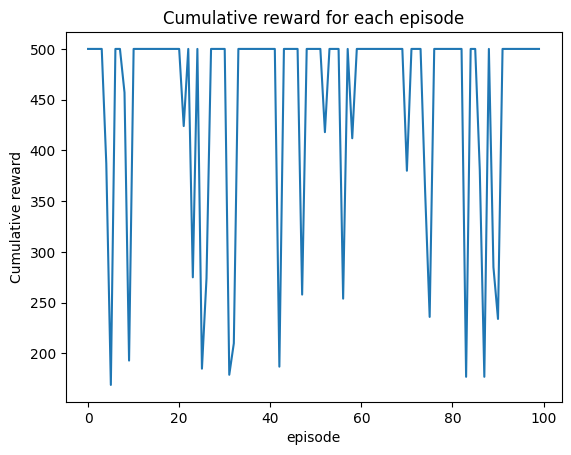

In [15]:
episode_results = np.array([play(env, agent) for _ in range(100)])

plt.plot(episode_results)
plt.title("Cumulative reward for each episode")
plt.ylabel("Cumulative reward")
plt.xlabel("episode")
plt.show()

Print the average reward over the 100 episodes.

In [16]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 450.12
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [17]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
play(env, agent)
env.close()
show_video()

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3147: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3147: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

# References
References consulted in the implementation of this notebook:

[1]: Chan, M. (2016, November 15). Cart-Pole Balancing with Q-Learning. Medium. https://medium.com/@tuzzer/cart-pole-balancing-with-q-learning-b54c6068d947

[2]: Q-Learning Controller for the Cart-Pole Problem. (n.d.). Retrieved March 20, 2025, from https://pages.cs.wisc.edu/~finton/qcontroller.html
